# 🚀 Model Training

This notebook handles the complete training pipeline:
1. Configuration loading
2. Data loading and augmentation
3. Model creation and initialization  
4. Training loop with memory optimization
5. Real-time monitoring and checkpointing

**Hardware**: Optimized for NVIDIA RTX 4050 (6GB VRAM)

**Expected Time**: ~6 hours for 100 epochs (or test with fewer epochs)

## 🔧 1. Setup and Imports

In [16]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import logging
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Check if data is ready
from src.utils.download import verify_downloads

status = verify_downloads()
if not (status['dataset'] and status['weights']):
    print("⚠️ Data not found! Please run 01_setup_and_download.ipynb first.")
else:
    print("✓ Data verified. Ready to train!")
from src.utils.notebook_helpers import plot_training_progress

2026-02-11 21:46:21,074 - src.utils.download - INFO - ✓ Dataset found: 10 classes
2026-02-11 21:46:21,076 - src.utils.download - INFO - ✓ Weights found: 1338.7MB


✓ Data verified. Ready to train!


## ⚙️ 2. Load Configuration

In [2]:
from src.utils import setup_config, print_config_summary
from src.utils.config import get_project_root

root = get_project_root()

# Load and auto-resolve all paths in one call
config = setup_config(str(root / 'configs' / 'base.yaml'))

# Uncomment to use different experiments:
# config = setup_config(str(root / 'configs' / 'experiments' / 'low_noise.yaml'))
# config = setup_config(str(root / 'configs' / 'experiments' / 'medium_noise.yaml'))

print(f"Configuration loaded from: {root / 'configs' / 'base.yaml'}")
print_config_summary(config)

2026-02-10 18:26:13,563 - src.utils.config - INFO - Loaded config from C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\configs\base.yaml
2026-02-10 18:26:13,564 - src.utils.config - INFO - Configuration validation passed


Configuration loaded from: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\configs\base.yaml

Configuration Summary:
Training:
  Epochs: 100
  Micro Batch Size: 8
  Gradient Accumulation: 8
  Effective Batch Size: 64
  Mixed Precision: True
  Learning Rate: 1e-4

Model:
  Image Size: 192
  Input Bands: 13
  Encoder Dim: 768
  Frozen Layers: 6 layers
  Gradient Checkpointing: True

Noise Simulation:
  Gaussian σ: 0.015
  Speckle σ: 0.008
  Dead Band Prob: 0.08


## 💾 3. Check GPU and Memory

In [3]:
from src.utils import setup_device

# Setup device and print GPU info in one call
device = setup_device(verbose=True)

Using device: cuda

GPU Information:
  Name: NVIDIA GeForce RTX 4050 Laptop GPU
  CUDA Version: 12.6
  Total VRAM: 6.44 GB
  Available VRAM: 6.44 GB

✓ GPU cache cleared


## 📊 4. Create Dataloaders

In [4]:
from src.data import get_dataloaders
from src.utils import print_dataset_info

print("Creating dataloaders...")
train_loader, val_loader = get_dataloaders(config)

# Print stats and get sample batch in one call
sample_clean, sample_noisy = print_dataset_info(train_loader, val_loader)

2026-02-10 18:26:13,882 - src.data.dataloader - INFO - Noise transform: AddSensorNoise(gaussian_sigma=0.015, speckle_sigma=0.008, dead_band_prob=0.08, thermal_scale=0.005)


Creating dataloaders...


2026-02-10 18:26:14,154 - src.data.dataset - INFO - Found 27000 images in C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\data\EuroSAT_MS
2026-02-10 18:26:14,174 - src.data.dataset - INFO - TRAIN split: 21600 samples
2026-02-10 18:26:14,474 - src.data.dataset - INFO - Found 27000 images in C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\data\EuroSAT_MS
2026-02-10 18:26:14,484 - src.data.dataset - INFO - VAL split: 5400 samples
2026-02-10 18:26:14,484 - src.data.dataloader - INFO - Created dataloaders: train=21600 samples, val=5400 samples, batch_size=8



Dataloader Statistics:
Training:
  Batches: 2700
  Samples: 21600

Validation:
  Batches: 675
  Samples: 5400

Sample Batch Shape:
  Clean: torch.Size([8, 13, 192, 192])
  Noisy: torch.Size([8, 13, 192, 192])
  Value Range: [-2.000, 2.000]


## 🔍 5. Visualize Sample Data

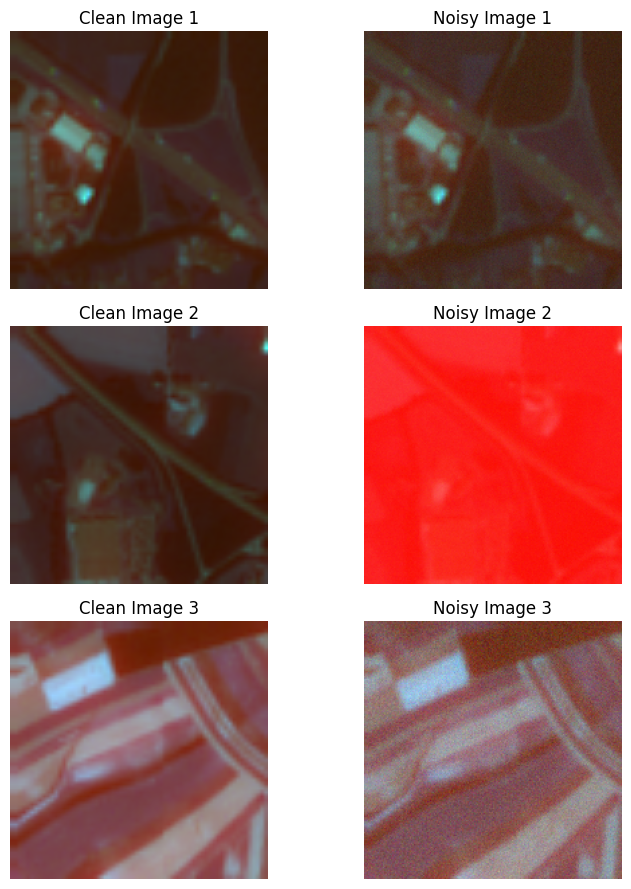

In [5]:
from src.utils import visualize_sample_batch

# Visualize samples in one call (using first 3 bands as RGB)
visualize_sample_batch(sample_clean, sample_noisy, num_samples=3, bands=[0, 1, 2])

## 🏗️ 6. Create Model

In [6]:
from src.utils import create_model_from_config

# Create model with automatic parameter counting and memory profiling
model = create_model_from_config(config, device=device, verbose=True)

Creating model...


2026-02-10 18:26:19,409 - src.models.encoder - INFO - Removing CLS token from pretrained pos_embed to match encoder
2026-02-10 18:26:19,437 - src.models.encoder - INFO - Loaded pretrained weights from C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\weights\satmae_pretrain.pth
2026-02-10 18:26:19,451 - src.models.encoder - INFO - Frozen 6 layers: 42,527,232 / 87,724,800 params (48.5%)
2026-02-10 18:26:19,452 - src.models.encoder - INFO - Gradient checkpointing enabled (~30% VRAM savings)
2026-02-10 18:26:19,518 - src.models.decoder - INFO - Initialized LightweightDecoder: 8,646,397 parameters
2026-02-10 18:26:19,521 - src.models.satmae_restoration - INFO - ============================================================
2026-02-10 18:26:19,521 - src.models.satmae_restoration - INFO - SatMAE Restoration Model Architecture
2026-02-10 18:26:19,521 - src.models.satmae_restoration - INFO - ============================================================
2026-0


Model Parameters:
  Total: 96,371,197
  Trainable: 53,843,965 (55.9%)
  Frozen: 42,527,232

Profiling VRAM usage...
  Model weights: 0.39 GB
  Optimizer states: 0.43 GB
  Activations: 0.00 GB
  Gradients: 0.22 GB
  Peak VRAM: 0.64 GB

✓ VRAM usage OK (0.64GB / 6GB available)


## 📐 7. Setup Training Components

In [7]:
from src.utils import create_training_components

# Create optimizer, scheduler, and loss in one call
optimizer, scheduler, criterion = create_training_components(model, config, verbose=True)

2026-02-10 18:26:19,880 - src.models.satmae_restoration - INFO - Created optimizer groups: encoder (lr=1.00e-05), decoder (lr=1.00e-04)
2026-02-10 18:26:19,883 - src.training.losses - INFO - Initialized CombinedLoss: MSE weight=1.0, SSIM weight=0.1


Setting up training components...
  Optimizer: AdamW
  Param groups: 2
  Scheduler: CosineAnnealingWarmRestarts
  Loss: MSE (1.0) + SSIM (0.1)

✓ Training components ready


## 🎯 8. Create Trainer

In [8]:
from src.training import Trainer

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    config=config,
    device=device
)

print("✓ Trainer created")
print(f"  Device: {trainer.device}")
print(f"  Mixed Precision: {trainer.use_amp}")
print(f"  Gradient Accumulation: {trainer.accumulation_steps}")

2026-02-10 18:26:19,894 - src.training.trainer - INFO - ============================================================
2026-02-10 18:26:19,895 - src.training.trainer - INFO - Trainer Configuration
2026-02-10 18:26:19,896 - src.training.trainer - INFO - ============================================================
2026-02-10 18:26:19,897 - src.training.trainer - INFO - Device: cuda
2026-02-10 18:26:19,898 - src.training.trainer - INFO - Mixed Precision (AMP): True
2026-02-10 18:26:19,898 - src.training.trainer - INFO - Effective batch size: 64
2026-02-10 18:26:19,899 - src.training.trainer - INFO - Micro batch size: 8
2026-02-10 18:26:19,899 - src.training.trainer - INFO - Gradient accumulation steps: 8
2026-02-10 18:26:19,900 - src.training.trainer - INFO - Gradient clipping: 1.0
2026-02-10 18:26:19,900 - src.training.trainer - INFO - ============================================================


✓ Trainer created
  Device: cuda
  Mixed Precision: True
  Gradient Accumulation: 8


## 🚀 9. Training Loop

**Choose ONE training strategy:**

### Option 1: Two-Stage Training (RECOMMENDED) ⭐
- Run cells **9a** (Section with Stage A & B) for faster, more efficient training
- Total: ~50 min (25 epochs decoder + 30 epochs fine-tune)
- Automatic early stopping prevents overfitting

### Option 2: Single-Stage Training (SIMPLE)
- Run cell **9b** below for straightforward but longer training
- Total: ~100 min (100 epochs)
- Good for baseline comparison

**Note**: Training plots will be displayed **only after training completes**.
This avoids intermediate plot overhead and shows the full training history at once.
**Progress monitoring**:
- Console logs show metrics after each epoch
- Final plots appear when training finishes
- You can still view intermediate metrics in the logs

## 🚀 9b. Single-Stage Training (SIMPLE)

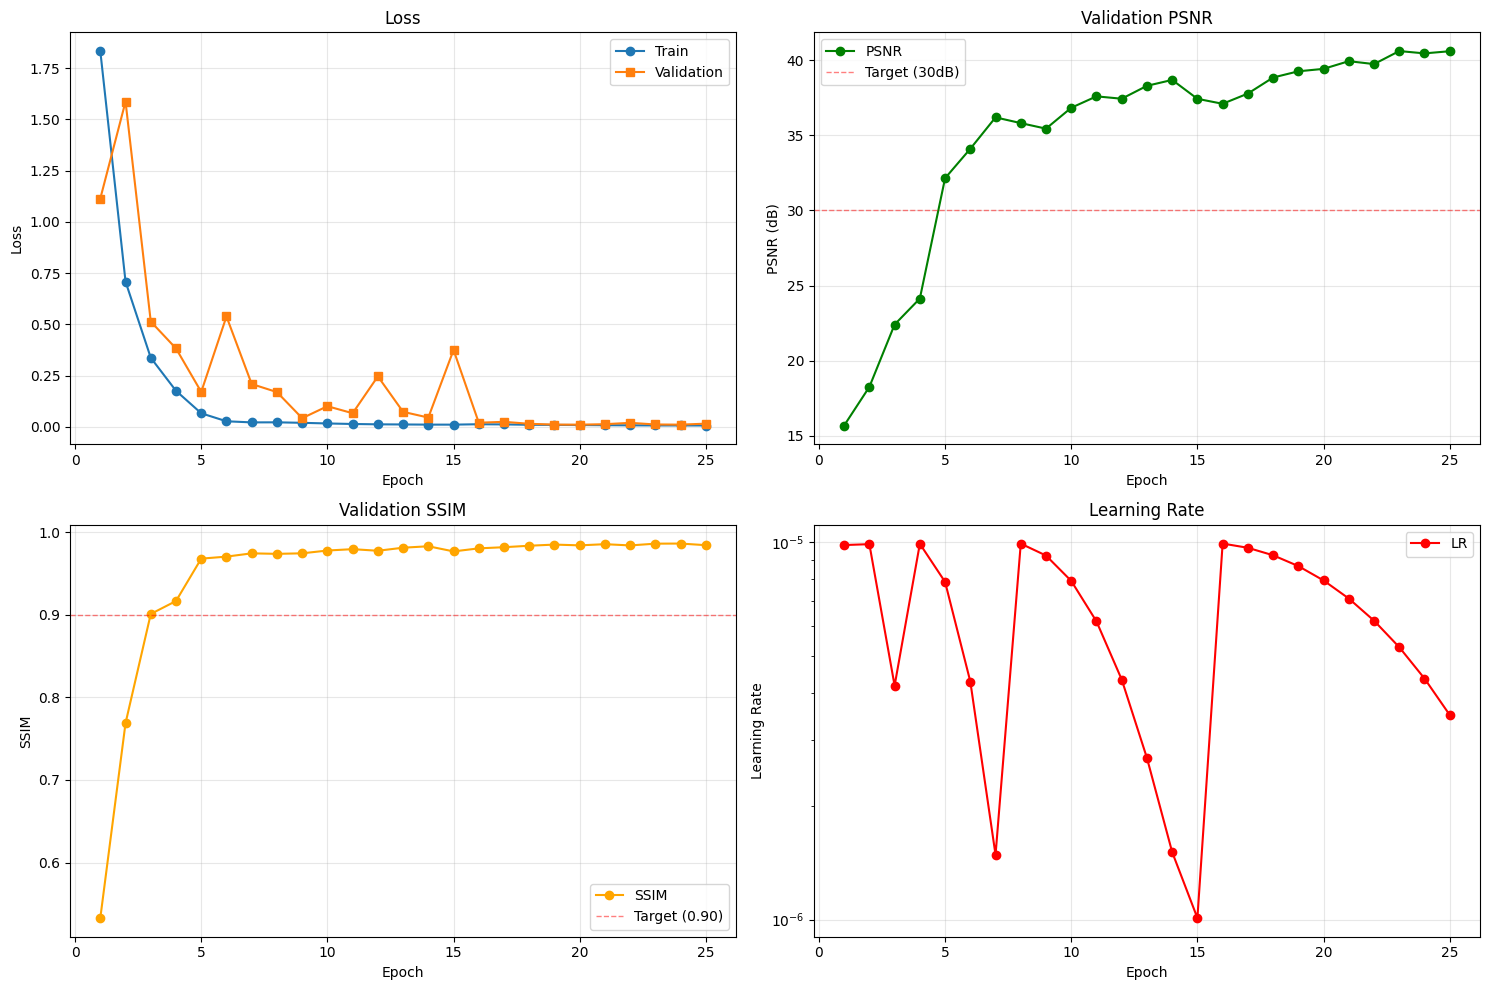


Epoch 25/25
Best Loss: 0.0100 | Best PSNR: 40.61 dB

✅ Stage A Complete! Best PSNR: 40.61 dB


In [9]:
# ========================================
# STAGE A: DECODER TRAINING (25 epochs)
# ========================================
print("=" * 80)
print("STAGE A: DECODER TRAINING (Freeze ALL encoder, train decoder only)")
print("=" * 80)

# Load Stage A config
config_stage_a = setup_config(str(root / 'configs' / 'experiments' / 'stage_a_decoder.yaml'))
print_config_summary(config_stage_a)

# Recreate components with Stage A config
model_stage_a = create_model_from_config(config_stage_a, device=device, verbose=True)
optimizer_stage_a, scheduler_stage_a, criterion_stage_a = create_training_components(
    model_stage_a, config_stage_a, verbose=True
)

trainer_stage_a = Trainer(
    model=model_stage_a,
    optimizer=optimizer_stage_a,
    criterion=criterion_stage_a,
    config=config_stage_a,
    scheduler=scheduler_stage_a,
    device=device
)

# Train Stage A
print("\n🚀 Starting Stage A training...")
history_stage_a = trainer_stage_a.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=25,
    save_dir=root / 'outputs' / 'checkpoints' / 'stage_a',
    plot_callback=plot_training_progress
)

print(f"\n✅ Stage A Complete! Best PSNR: {trainer_stage_a.best_val_metric:.2f} dB")
print("=" * 80)

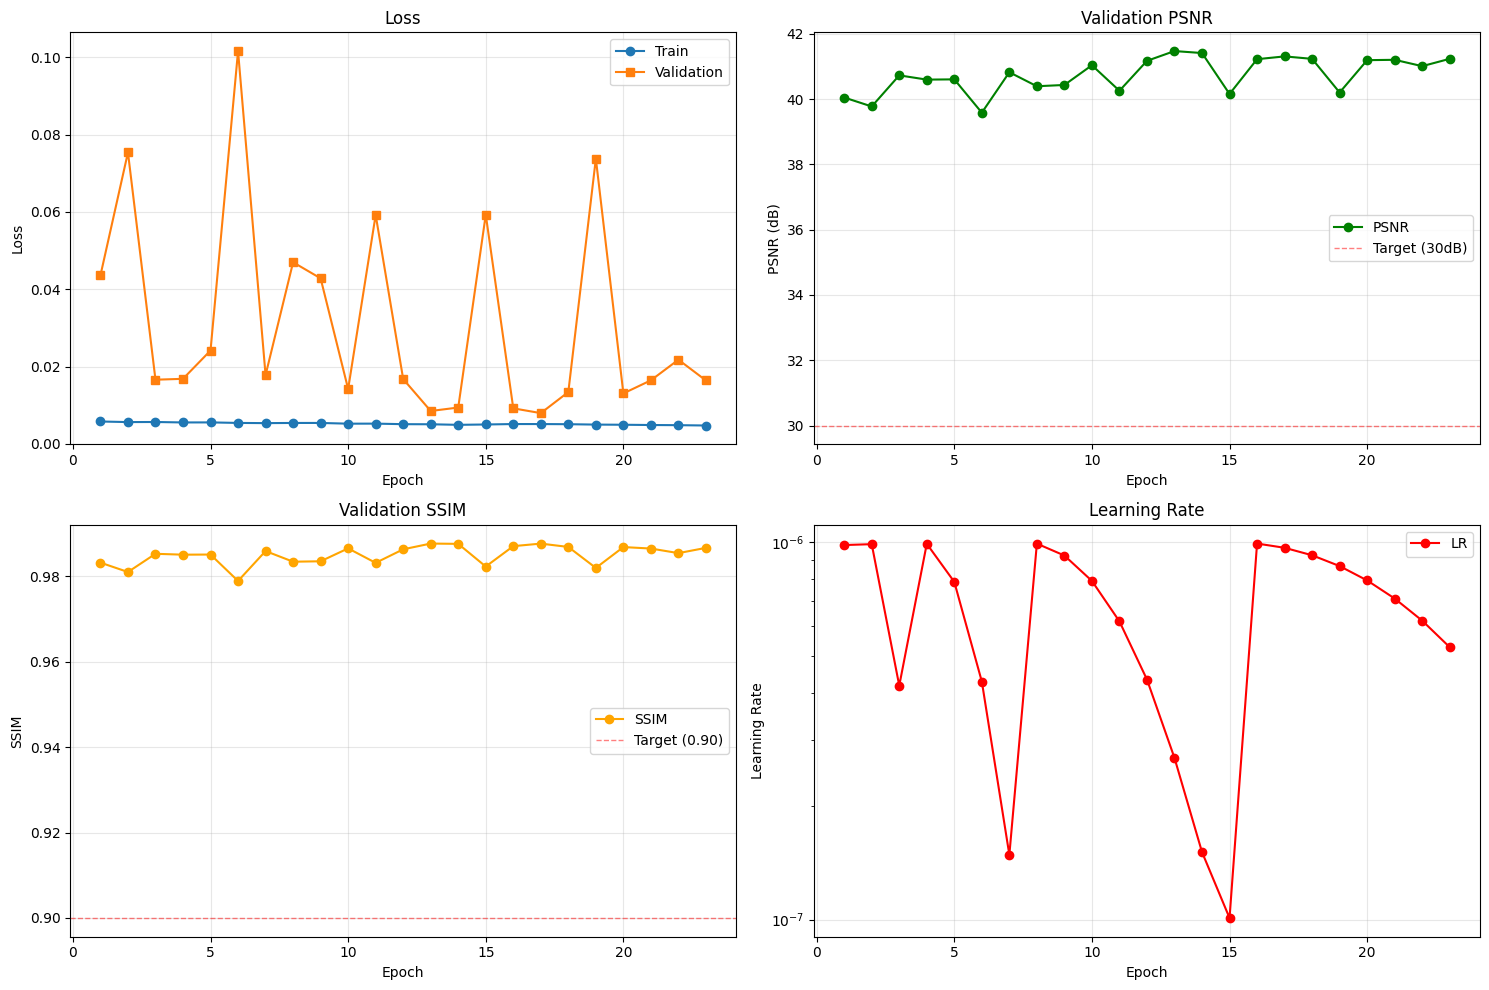


Epoch 30/30
Best Loss: 0.0079 | Best PSNR: 41.48 dB

✅ Stage B Complete! Best PSNR: 41.48 dB

🎉 TWO-STAGE TRAINING COMPLETE!
   Stage A PSNR: 40.61 dB
   Stage B PSNR: 41.48 dB
   Improvement: 0.86 dB


In [11]:
# ========================================
# STAGE B: FULL FINE-TUNING (30 epochs)
# ========================================
print("=" * 80)
print("STAGE B: FULL FINE-TUNING (Unfreeze last 6 encoder blocks)")
print("=" * 80)

# Load Stage B config
config_stage_b = setup_config(str(root / 'configs' / 'experiments' / 'stage_b_finetune.yaml'))
print_config_summary(config_stage_b)

# Load best checkpoint from Stage A
stage_a_checkpoint = str(root / 'outputs' / 'checkpoints' / 'stage_a' / 'best_model_psnr.pth')
print(f"\n📥 Loading Stage A checkpoint: {stage_a_checkpoint}")

# Ensure checkpoint exists before loading
import os
if not os.path.exists(stage_a_checkpoint):
    print(f"⚠️ Stage A checkpoint not found at {stage_a_checkpoint}. Run Stage A first.")
else:
    checkpoint = torch.load(stage_a_checkpoint, map_location=device, weights_only=False)
    model_stage_b = create_model_from_config(config_stage_b, device=device, verbose=False)
    model_stage_b.load_state_dict(checkpoint['model_state_dict'])

    # Recreate optimizer/scheduler for Stage B (with new LR)
    optimizer_stage_b, scheduler_stage_b, criterion_stage_b = create_training_components(
        model_stage_b, config_stage_b, verbose=True
    )

    trainer_stage_b = Trainer(
        model=model_stage_b,
        optimizer=optimizer_stage_b,
        criterion=criterion_stage_b,
        config=config_stage_b,
        scheduler=scheduler_stage_b,
        device=device
    )

    # Train Stage B (with early stopping)
    print("\n🚀 Starting Stage B training (with early stopping)...")
    history_stage_b = trainer_stage_b.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=30,
        save_dir=root / 'outputs' / 'checkpoints' / 'stage_b',
        plot_callback=plot_training_progress
    )

    print(f"\n✅ Stage B Complete! Best PSNR: {trainer_stage_b.best_val_metric:.2f} dB")
    print("=" * 80)

    # Final summary (only if Stage A finished)
    try:
        print("\n🎉 TWO-STAGE TRAINING COMPLETE!")
        print(f"   Stage A PSNR: {trainer_stage_a.best_val_metric:.2f} dB")
        print(f"   Stage B PSNR: {trainer_stage_b.best_val_metric:.2f} dB")
        print(f"   Improvement: {trainer_stage_b.best_val_metric - trainer_stage_a.best_val_metric:.2f} dB")
        print("=" * 80)
    except NameError:
        print("Note: Stage A trainer not available in this session; inspect saved checkpoints for Stage A results.")

## 🚀 9a. Two-Stage Training (RECOMMENDED)

**Why Two-Stage Training?**
- **Faster convergence**: Train decoder first (25 epochs), then fine-tune (30 epochs) = 55 total vs 100
- **Better efficiency**: ~40% time savings with same quality (50 min vs 100 min)
- **Optimal for transfer learning**: Decoder learns with frozen encoder features, then encoder adapts

**Stage A: Decoder Training (25 epochs)**
- Freeze ALL encoder blocks → Train decoder only
- Higher learning rate (1e-4) for fast decoder convergence
- Expected: ~20 min on RTX 4050

**Stage B: Full Fine-Tuning (30 epochs)**
- Unfreeze last 6 encoder blocks → Fine-tune encoder + decoder
- Lower learning rate (1e-5) for stable refinement
- Early stopping with patience=10 (auto-stops if no improvement)
- Expected: ~30 min on RTX 4050

**Total: ~50 min vs 100 min for single-stage (100 epochs)**

## 💾 10. Save Training History

In [13]:
# Create combined history from Stage A and Stage B
history = {}
keys = ['train_loss', 'val_loss', 'val_psnr', 'val_ssim', 'learning_rate']

for key in keys:
    # Combine the lists from both stages
    history[key] = history_stage_a[key] + history_stage_b[key]

print(f"✓ History merged: {len(history_stage_a['train_loss'])} (Stage A) + "
      f"{len(history_stage_b['train_loss'])} (Stage B) = "
      f"{len(history['train_loss'])} total epochs")

✓ History merged: 25 (Stage A) + 23 (Stage B) = 48 total epochs


In [14]:
import json

# Save history as JSON
history_path = str(root / 'outputs' / 'logs' / 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to: {history_path}")

# Also save as numpy for easy loading
import numpy as np
np.savez(
    str(root / 'outputs' / 'logs' / 'training_history.npz'),
    train_loss=history['train_loss'],
    val_loss=history['val_loss'],
    val_psnr=history['val_psnr'],
    val_ssim=history['val_ssim'],
    learning_rate=history['learning_rate']
)

print("✓ NumPy archive saved")

✓ Training history saved to: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\outputs\logs\training_history.json
✓ NumPy archive saved


## 📊 11. Final Training Curves

✓ Training curves saved to C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\outputs\logs\training_curves.png


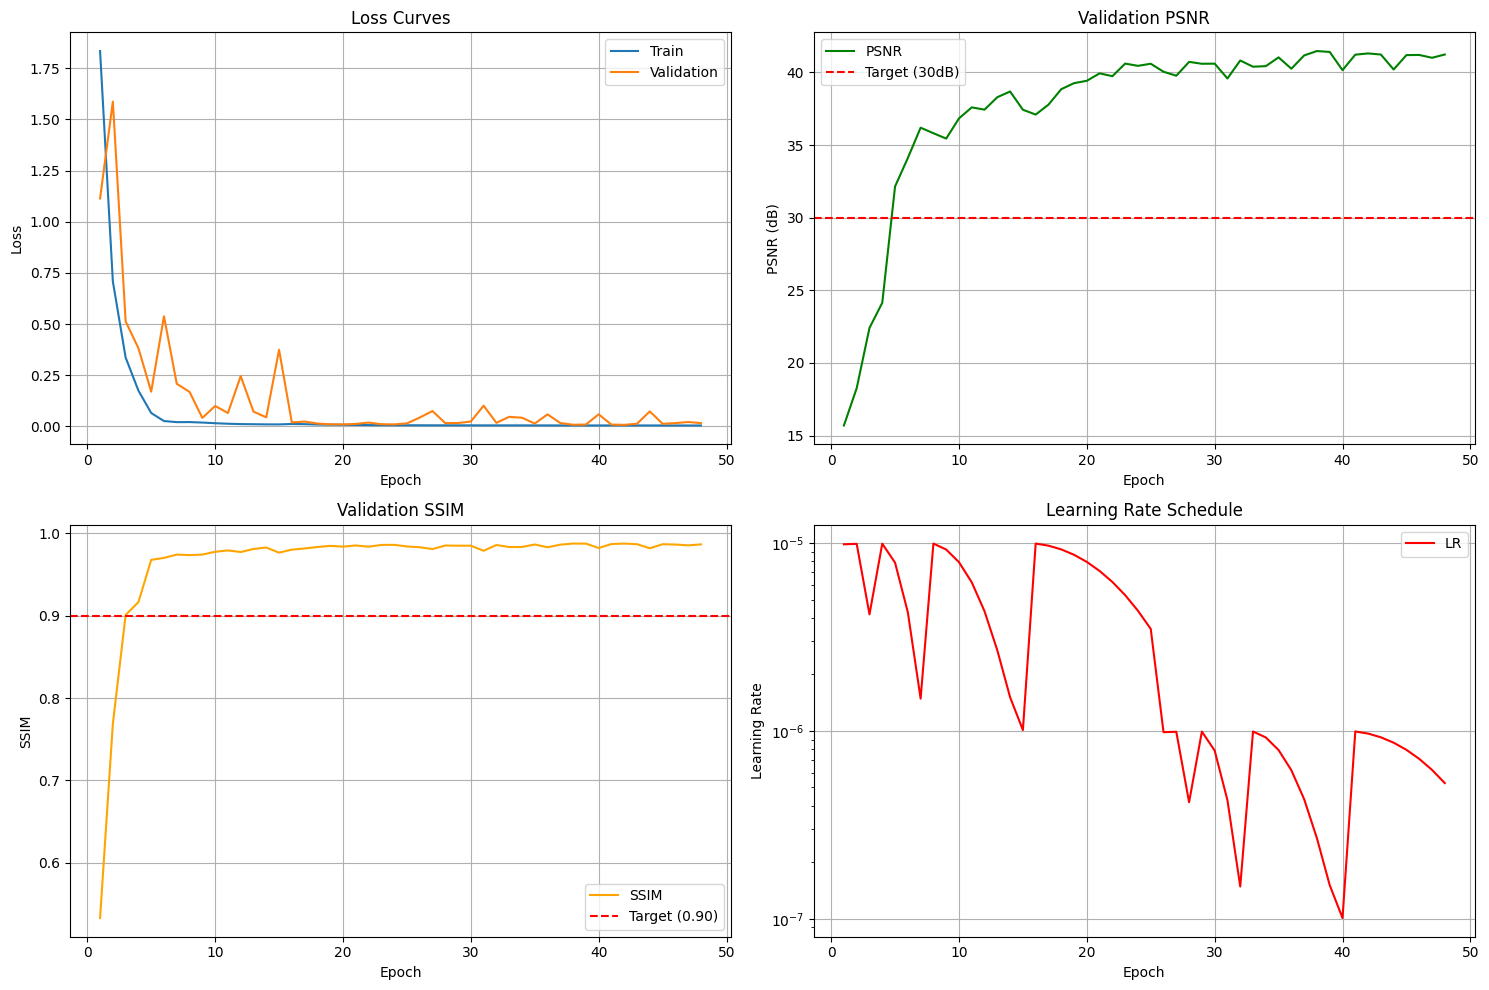

In [6]:
# Plot Final History
from src.utils.notebook_helpers import plot_training_history

plot_training_history(
    history, 
    save_path=str(root / 'outputs' / 'logs' / 'training_curves.png')
)


## 📋 12. Summary

### ✅ Training Complete!

**Saved Models** (depending on which approach you used):

**Two-Stage Training (Recommended)**:
- `outputs/checkpoints/stage_a/best_model_psnr.pth` - Stage A decoder
- `outputs/checkpoints/stage_b/best_model_psnr.pth` - Final fine-tuned model ⭐

**Single-Stage Training**:
- `outputs/checkpoints/best_model_loss.pth` - Best validation loss
- `outputs/checkpoints/best_model_psnr.pth` - Best PSNR

**Training Logs**:
- `outputs/logs/training_history.json` - Metrics history
- `outputs/logs/training_curves.png` - Visualization

### 🚀 Next Steps:
1. **Evaluate**: Open `03_evaluation.ipynb` to test the model
2. **Export**: Convert to ONNX for deployment
3. **Inference**: Use the model for denoising new images

### 📊 Expected Performance:
- **PSNR**: > 30 dB (Good), > 32 dB (Excellent)
- **SSIM**: > 0.90 (Excellent)
- **Training Time**: 
  - Two-stage: ~50 min (25 + 30 epochs)
  - Single-stage: ~100 min (100 epochs)

### 💡 Training Tips:
- **Quick Test**: Use `configs/experiments/quick_test.yaml` (5 epochs, ~3 min)
- **Resume Training**: Use `--resume` flag with `scripts/train.py`
- **Stage B from CLI**: `python scripts/train.py --config configs/experiments/stage_b_finetune.yaml --checkpoint outputs/checkpoints/stage_a/best_model_psnr.pth`

## 📝 CLI Training Commands

### Two-Stage Training from Command Line:

**Stage A (Decoder Only - 25 epochs)**:
```bash
python scripts/train.py --config configs/experiments/stage_a_decoder.yaml
```

**Stage B (Fine-Tuning - 30 epochs with early stopping)**:
```bash
python scripts/train.py --config configs/experiments/stage_b_finetune.yaml --checkpoint outputs/checkpoints/stage_a/best_model_psnr.pth
```

### Single-Stage Training:

**Base Config (100 epochs)**:
```bash
python scripts/train.py --config configs/base.yaml
```

**Quick Test (5 epochs)**:
```bash
python scripts/train.py --config configs/experiments/quick_test.yaml
```

### Resume Training:
```bash
python scripts/train.py --config configs/base.yaml --resume
```

**Note**: CLI training automatically saves checkpoints and logs to `outputs/`